<a href="https://colab.research.google.com/github/ReyhaneTaj/PINNs/blob/main/InverseMode_Ln.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip -q install deepxde

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.8/179.8 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.3/100.3 kB 9.0 MB/s eta 0:00:00


Case0,
Training Data : Analytical Solution,
IC : log(U_dc / R).

Compiling model...
Building feed-forward neural network...
'build' took 0.065397 s



/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 1.617731 s

Training model...

Step      Train loss                        Test loss                         Test metric   
0         [8.34e-01, 0.00e+00, 4.01e+01]    [8.34e-01, 0.00e+00, 4.01e+01]    [1.00e+00]    
1000      [7.83e-01, 2.39e-01, 1.47e+00]    [7.83e-01, 2.39e-01, 1.47e+00]    [1.00e+00]    
2000      [6.36e-01, 1.94e-01, 1.19e+00]    [6.36e-01, 1.94e-01, 1.19e+00]    [1.00e+00]    
3000      [5.47e-01, 1.67e-01, 1.02e+00]    [5.47e-01, 1.67e-01, 1.02e+00]    [1.00e+00]    
4000      [4.81e-01, 1.47e-01, 8.99e-01]    [4.81e-01, 1.47e-01, 8.99e-01]    [1.00e+00]    
5000      [4.42e-01, 6.35e-02, 8.71e-01]    [4.42e-01, 6.35e-02, 8.71e-01]    [1.00e+00]    
6000      [3.83e-01, 1.16e-01, 7.12e-01]    [3.83e-01, 1.16e-01, 7.12e-01]    [1.00e+00]    
7000      [3.55e-01, 1.42e-01, 5.98e-01]    [3.55e-01, 1.42e-01, 5.98e-01]    [1.00e+00]    
8000      [3.10e-01, 9.37e-02, 5.77e-01]    [3.10e-01, 9.37e-02, 5.77e-01]    [1.00e+00]    
9000      [2.76e-01, 8.8

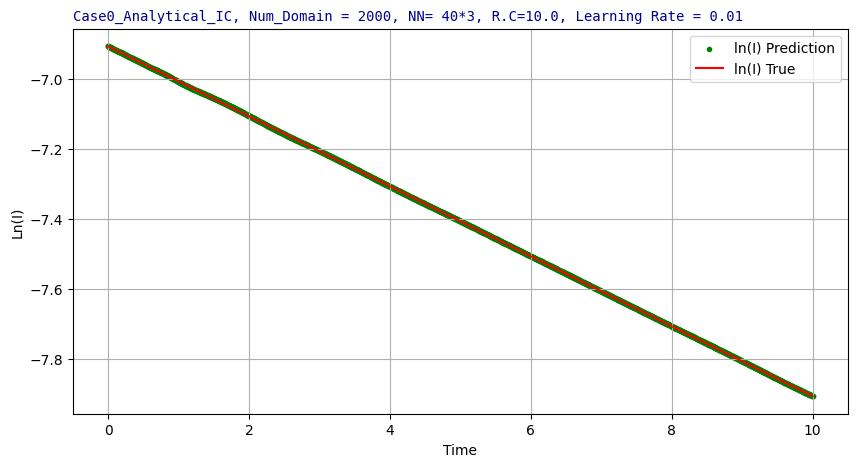

In [ ]:
#.....Ln_Case0.....#
"""Backend supported: tensorflow.compat.v1, tensorflow, pytorch, jax"""
import deepxde as dde
import numpy as np
import matplotlib.pyplot as plt
import random
import tensorflow as tf

#seed = 0
#random.seed(seed)
#np.random.seed(seed)
#tf.random.set_seed(seed)

#Define constants.
U_dc = 1.0

#Time Limitation.
T = 10.0
N_Domain = 35
LR = 0.01
n = 40
l = 3
#Define constants for analytical part.
R_0 = 1000.0
C_0 = 0.01
m = R_0*C_0
#Define parameters as variables.
R = dde.Variable(1.0)
C = dde.Variable(1.0)

# Define the analytical solution for dI/dt + I/(RC) = 0
def analytical_solution(t, R, C):
    return (-t/ (R*C))+ np.log(U_dc/R)


def gen_traindata():
    # Generate training data using the analytical solution
    t = np.linspace(0.0, T, 30)  # Adjust the number of points as needed
    ln_I_train = analytical_solution(t, R_0, C_0)

    # Return the reshaped I_train, not a commented-out variable
    return np.reshape(t,(-1,1)), np.reshape(ln_I_train,(-1,1))


# Define the Lorenz system
def Lorenz_system(t, ln_I):
    dln_I_t = dde.grad.jacobian(ln_I, t, i=0)
    return [dln_I_t + 1 / (R * C)]

def boundary(_, on_initial):
    return on_initial

geom = dde.geometry.TimeDomain(0, T)

# Initial conditions
ic0 = dde.icbc.IC(geom, lambda X: tf.math.log(U_dc / R) , boundary, component=0)


# Get the train data
observe_t, ob_ln_I = gen_traindata()
observe_ln_I = dde.icbc.PointSetBC(observe_t, ob_ln_I[:,0:1], component=0)


data = dde.data.PDE(
    geom,
    Lorenz_system,
    [ic0, observe_ln_I],
    num_domain=N_Domain,
    num_boundary=0,
    anchors=observe_t,
)

net = dde.nn.FNN([1] + [n] * l + [1], "tanh", "Glorot uniform")
model = dde.Model(data, net)

external_trainable_variables = [R, C]
variable = dde.callbacks.VariableValue(
    external_trainable_variables, period=600, filename="variables.dat"
)

# Train using adam
model.compile(
    "adam", lr=LR, external_trainable_variables=external_trainable_variables, metrics=['accuracy']
)
losshistory, train_state = model.train(iterations=20000, callbacks=[variable])

# Train using L-BFGS
model.compile("L-BFGS", external_trainable_variables=external_trainable_variables,  metrics=['accuracy'])
losshistory, train_state = model.train(callbacks=[variable])


# Make predictions
t_test = data.test_x
ln_I_pred = model.predict(t_test)

#Make true diagram
t_true = np.linspace(0, T, 20).reshape(-1, 1)
ln_I_train = analytical_solution(t_true, R_0, C_0)

# Create a single figure for all plots
plt.figure(figsize=(10, 5))

# Plot log(I) Prediction
plt.scatter(t_test, ln_I_pred, label='ln(I) Prediction', c='green' , marker='.')
# Plot log(I) True
plt.plot(t_true, ln_I_train, label='ln(I) True', c='red')


plt.xlabel('Time')
plt.ylabel('Ln(I)')
plt.legend()
plt.title(f'Case0_Analytical_IC, Num_Domain = {N_Domain}, NN= {n}*{l}, R.C={RC}, Learning Rate = {LR}', loc='left', fontdict={'family': 'monospace', 'color':  'darkblue', 'weight': 'normal', 'size': 10})
plt.grid(True)

plt.show()


In [ ]:
!cat variables.dat

0 [1.00e+00, 1.00e+00]
600 [4.35e+00, 3.63e-01]
1200 [6.89e+00, 2.44e-01]
1800 [9.25e+00, 1.91e-01]
2400 [1.16e+01, 1.59e-01]
3000 [1.40e+01, 1.36e-01]
3600 [1.65e+01, 1.19e-01]
4200 [1.92e+01, 1.06e-01]
4800 [2.20e+01, 9.47e-02]
5400 [2.51e+01, 8.56e-02]
6000 [2.83e+01, 7.78e-02]
6600 [3.17e+01, 7.14e-02]
7200 [3.53e+01, 6.56e-02]
7800 [3.91e+01, 6.08e-02]
8400 [4.30e+01, 5.62e-02]
9000 [4.71e+01, 5.23e-02]
9600 [5.14e+01, 4.93e-02]
10200 [5.58e+01, 4.59e-02]
10800 [6.03e+01, 4.38e-02]
11400 [6.49e+01, 4.16e-02]
12000 [6.96e+01, 3.94e-02]
12600 [7.44e+01, 3.76e-02]
13200 [7.93e+01, 3.63e-02]
13800 [8.42e+01, 3.49e-02]
14400 [8.92e+01, 3.27e-02]
15000 [9.43e+01, 3.20e-02]
15600 [9.94e+01, 3.08e-02]
16200 [1.05e+02, 2.97e-02]
16800 [1.10e+02, 2.86e-02]
17400 [1.15e+02, 2.77e-02]
18000 [1.20e+02, 2.69e-02]
18600 [1.25e+02, 2.59e-02]
19200 [1.31e+02, 2.51e-02]
19800 [1.36e+02, 2.48e-02]
20000 [1.38e+02, 2.43e-02]
20000 [1.38e+02, 2.43e-02]
20400 [1.70e+02, 6.46e-02]
21000 [1.87e+02, 5.57e

Case0,
Training Data : Analytical Solution,
IC-Free.


In [ ]:
!pip -q install deepxde

Compiling model...
Building feed-forward neural network...
'build' took 0.153250 s

'compile' took 1.093177 s

Training model...

Step      Train loss              Test loss               Test metric
0         [9.80e-01, 4.79e+01]    [9.80e-01, 4.79e+01]    []  
1000      [1.18e-02, 1.22e-03]    [1.18e-02, 1.22e-03]    []  
2000      [4.77e-03, 6.54e-04]    [4.77e-03, 6.54e-04]    []  
3000      [2.65e-03, 3.71e-04]    [2.65e-03, 3.71e-04]    []  
4000      [1.61e-03, 2.24e-04]    [1.61e-03, 2.24e-04]    []  
5000      [1.10e-03, 1.57e-04]    [1.10e-03, 1.57e-04]    []  
6000      [6.53e-04, 9.06e-05]    [6.53e-04, 9.06e-05]    []  
7000      [4.18e-04, 5.76e-05]    [4.18e-04, 5.76e-05]    []  
8000      [2.57e-04, 1.11e-04]    [2.57e-04, 1.11e-04]    []  
9000      [2.05e-04, 9.93e-04]    [2.05e-04, 9.93e-04]    []  
10000     [1.01e-04, 2.74e-05]    [1.01e-04, 2.74e-05]    []  
11000     [5.72e-05, 7.93e-06]    [5.72e-05, 7.93e-06]    []  
12000     [3.06e-05, 3.24e-05]    [3.06e-05,

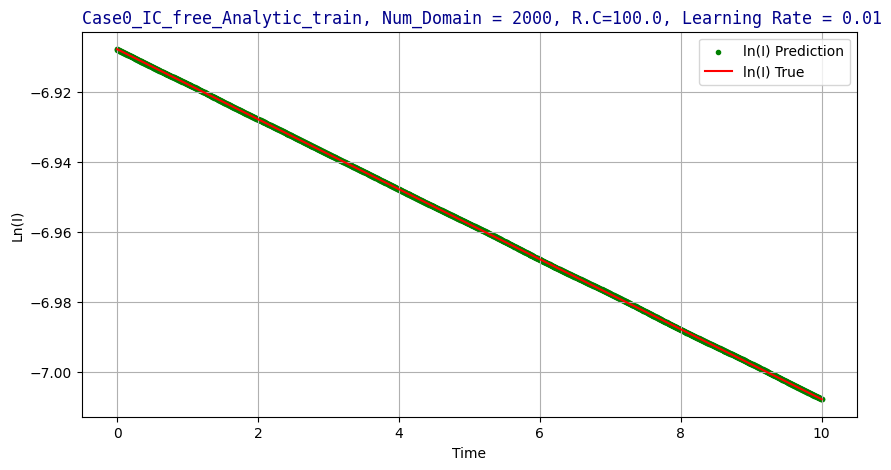

In [ ]:
#.....Ln_Case0.....IC_free#
"""Backend supported: tensorflow.compat.v1, tensorflow, pytorch, jax"""
import deepxde as dde
import numpy as np
import matplotlib.pyplot as plt
import random
import tensorflow as tf

#seed = 0
#random.seed(seed)
#np.random.seed(seed)
#tf.random.set_seed(seed)

#Define constants.
U_dc = 1.0

#Time Limitation.
T = 10.0
N_Domain = 2000
LR = 0.01
n = 40
l = 3
#Define constants for analytical part.
R_0 = 1000.0
C_0 = 0.1
m = R_0*C_0
#Define parameters as variables.
R = dde.Variable(1.0)
C = dde.Variable(1.0)

# Define the analytical solution for dI/dt + I/(RC) = 0
def analytical_solution(t, R, C):
    return (-t/ (R*C))+ np.log(U_dc/R)


def gen_traindata():
    # Generate training data using the analytical solution
    t = np.linspace(0.0, T, 30)  # Adjust the number of points as needed
    ln_I_train = analytical_solution(t, R_0, C_0)

    # Return the reshaped I_train, not a commented-out variable
    return np.reshape(t,(-1,1)), np.reshape(ln_I_train,(-1,1))


# Define the Lorenz system
def Lorenz_system(t, ln_I):
    dln_I_t = dde.grad.jacobian(ln_I, t, i=0)
    return [dln_I_t + 1 / (R * C)]

def boundary(_, on_initial):
    return on_initial

geom = dde.geometry.TimeDomain(0, T)



# Get the train data
observe_t, ob_Ln_I = gen_traindata()
observe_Ln_I = dde.icbc.PointSetBC(observe_t, ob_Ln_I, component=0)


data = dde.data.PDE(
    geom,
    Lorenz_system,
    [observe_Ln_I],
    num_domain=N_Domain,
    num_boundary=0,
    anchors=observe_t,
)

net = dde.nn.FNN([1] + [40] * 3 + [1], "tanh", "Glorot uniform")
model = dde.Model(data, net)

external_trainable_variables = [R, C]
variable = dde.callbacks.VariableValue(
    external_trainable_variables, period=600, filename="variables.dat"
)

# Train using adam
model.compile(
    "adam", lr=LR, external_trainable_variables=external_trainable_variables
)
losshistory, train_state = model.train(iterations=20000, callbacks=[variable])

# Train using L-BFGS
model.compile("L-BFGS", external_trainable_variables=external_trainable_variables)
losshistory, train_state = model.train(callbacks=[variable])


# Make predictions
t_test = data.test_x
ln_I_pred = model.predict(t_test)

#Make true diagram
t_true = np.linspace(0, T, 20).reshape(-1, 1)
ln_I_train = analytical_solution(t_true, R_0, C_0)

# Create a single figure for all plots
plt.figure(figsize=(10, 5))

# Plot log(I) Prediction
plt.scatter(t_test, ln_I_pred, label='ln(I) Prediction', c='green' , marker='.')
# Plot log(I) True
plt.plot(t_true, ln_I_train, label='ln(I) True', c='red')


plt.xlabel('Time')
plt.ylabel('Ln(I)')
plt.legend()
plt.title(f'Case0_IC_free_Analytic_train, Num_Domain = {N_Domain}, NN={n}*{l}, R.C={m}, Learning Rate = {LR}', loc='left', fontdict={'family': 'monospace', 'color':  'darkblue', 'weight': 'normal', 'size': 12})
plt.grid(True)

plt.show()


RC : Variable

In [ ]:
!pip install -q deepxde

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.3/172.3 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.3/100.3 kB 8.8 MB/s eta 0:00:00


No backend selected.
Finding available backend...


Using backend: tensorflow.compat.v1
Other supported backends: tensorflow, pytorch, jax, paddle.
paddle supports more examples now and is recommended.
Instructions for updating:
non-resource variables are not supported in the long term


Found tensorflow.compat.v1
Setting the default backend to "tensorflow.compat.v1". You can change it in the ~/.deepxde/config.json file or export the DDE_BACKEND environment variable. Valid options are: tensorflow.compat.v1, tensorflow, pytorch, jax, paddle (all lowercase)
Compiling model...
Building feed-forward neural network...
'build' took 0.067723 s



/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 0.341959 s

Training model...

Step      Train loss              Test loss               Test metric   
0         [8.44e-01, 4.51e+01]    [8.44e-01, 4.51e+01]    [1.00e+00]    
1000      [2.49e-02, 3.38e-03]    [2.49e-02, 3.38e-03]    [1.00e+00]    
2000      [1.03e-02, 1.56e-03]    [1.03e-02, 1.56e-03]    [1.00e+00]    
3000      [5.45e-03, 6.86e-04]    [5.45e-03, 6.86e-04]    [1.00e+00]    
4000      [2.74e-03, 6.52e-04]    [2.74e-03, 6.52e-04]    [1.00e+00]    
5000      [1.51e-03, 2.01e-04]    [1.51e-03, 2.01e-04]    [1.00e+00]    
6000      [7.56e-04, 1.42e-04]    [7.56e-04, 1.42e-04]    [1.00e+00]    
7000      [3.05e-04, 8.30e-04]    [3.05e-04, 8.30e-04]    [1.00e+00]    
8000      [1.24e-04, 1.81e-05]    [1.24e-04, 1.81e-05]    [1.00e+00]    
9000      [3.67e-05, 5.04e-06]    [3.67e-05, 5.04e-06]    [1.00e+00]    
10000     [7.36e-06, 4.31e-04]    [7.36e-06, 4.31e-04]    [1.00e+00]    
11000     [1.93e-06, 1.77e-07]    [1.93e-06, 1.77e-07]    [1.00e+00]    
12000

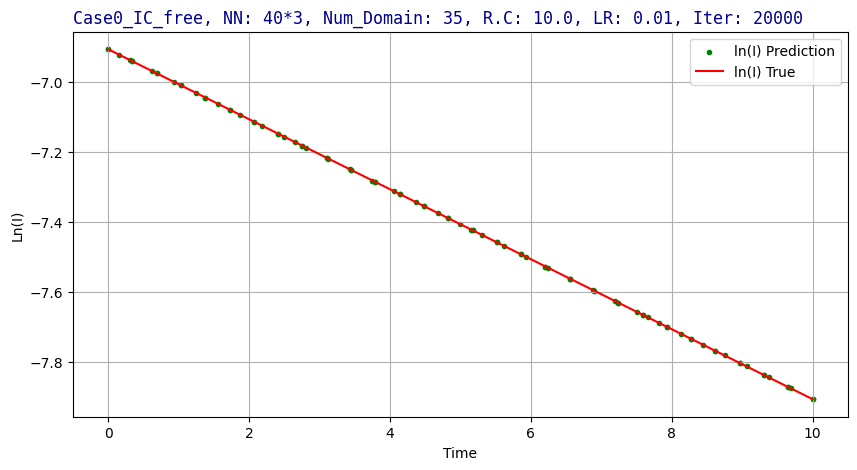

In [ ]:
#.....Ln_Case0.....IC_free#
"""Backend supported: tensorflow.compat.v1, tensorflow, pytorch, jax"""
import deepxde as dde
import numpy as np
import matplotlib.pyplot as plt
import random
import tensorflow as tf

#seed = 0
#random.seed(seed)
#np.random.seed(seed)
#tf.random.set_seed(seed)

#Define constants.
U_dc = 1.0

#Time Limitation.
T = 10.0
N_Domain = 35
LR = 0.01
n = 40
l = 3
#Define constants for analytical part.
R_0 = 1000.0
C_0 = 0.01
m = R_0 * C_0
#Define parameters as variables.

RC = dde.Variable(1.0)

# Define the analytical solution for dI/dt + I/(RC) = 0
def analytical_solution(t, R, RC):
    return (-t/ (RC))+ np.log(U_dc/R)


def gen_traindata():
    # Generate training data using the analytical solution
    t = np.linspace(0.0, T, 30)  # Adjust the number of points as needed
    ln_I_train = analytical_solution(t, R_0, m)

    # Return the reshaped I_train, not a commented-out variable
    return np.reshape(t,(-1,1)), np.reshape(ln_I_train,(-1,1))


# Define the Lorenz system
def Lorenz_system(t, ln_I):
    dln_I_t = dde.grad.jacobian(ln_I, t, i=0)
    return [dln_I_t + 1 / (RC)]

def boundary(_, on_initial):
    return on_initial

geom = dde.geometry.TimeDomain(0, T)



# Get the train data
observe_t, ob_Ln_I = gen_traindata()
observe_Ln_I = dde.icbc.PointSetBC(observe_t, ob_Ln_I, component=0)


data = dde.data.PDE(
    geom,
    Lorenz_system,
    [observe_Ln_I],
    num_domain=N_Domain,
    num_boundary=0,
    anchors=observe_t,
)

net = dde.nn.FNN([1] + [40] * 3 + [1], "tanh", "Glorot uniform")
model = dde.Model(data, net)

external_trainable_variables = [RC]
variable = dde.callbacks.VariableValue(
    external_trainable_variables, period=600, filename="variables.dat"
)

# Train using adam
model.compile(
    "adam", lr=LR, external_trainable_variables=external_trainable_variables, metrics=['accuracy']
)
losshistory, train_state = model.train(iterations=20000, callbacks=[variable])

# Train using L-BFGS
model.compile("L-BFGS", external_trainable_variables=external_trainable_variables)
losshistory, train_state = model.train(callbacks=[variable])


# Make predictions
t_test = data.test_x
ln_I_pred = model.predict(t_test)

#Make true diagram
t_true = np.linspace(0, T, 20).reshape(-1, 1)
ln_I_train = analytical_solution(t_true, R_0, m)

# Create a single figure for all plots
plt.figure(figsize=(10, 5))

# Plot log(I) Prediction
plt.scatter(t_test, ln_I_pred, label='ln(I) Prediction', c='green' , marker='.')
# Plot log(I) True
plt.plot(t_true, ln_I_train, label='ln(I) True', c='red')


plt.xlabel('Time')
plt.ylabel('Ln(I)')
plt.legend()
plt.title(f'Case0_IC_free, NN: {n}*{l}, Num_Domain: {N_Domain}, R.C: {m}, LR: {LR}, Iter: 20000', loc='left', fontdict={'family': 'monospace', 'color':  'darkblue', 'weight': 'normal', 'size': 12})
plt.grid(True)

plt.show()


In [ ]:
!cat variables.dat

0 [1.00e+00]
600 [2.95e+00]
1200 [3.75e+00]
1800 [4.36e+00]
2400 [4.90e+00]
3000 [5.39e+00]
3600 [5.86e+00]
4200 [6.31e+00]
4800 [6.74e+00]
5400 [7.17e+00]
6000 [7.59e+00]
6600 [7.99e+00]
7200 [8.37e+00]
7800 [8.73e+00]
8400 [9.06e+00]
9000 [9.35e+00]
9600 [9.59e+00]
10200 [9.77e+00]
10800 [9.90e+00]
11400 [9.97e+00]
12000 [1.00e+01]
12600 [1.00e+01]
13200 [1.00e+01]
13800 [1.00e+01]
14400 [1.00e+01]
15000 [1.00e+01]
15600 [1.00e+01]
16200 [1.00e+01]
16800 [1.00e+01]
17400 [1.00e+01]
18000 [1.01e+01]
18600 [1.00e+01]
19200 [1.01e+01]
19800 [1.00e+01]
20000 [1.00e+01]
20000 [1.00e+01]
20223 [1.00e+01]


In [ ]:
# Predict the current at t=0
ln_I_pred_at_t0 = model.predict(np.array([[0.0]]))

# Convert ln(I) to I using the inverse of the natural logarithm
I_pred_at_t0 = np.exp(ln_I_pred_at_t0)

# Print the predicted current at t=0
print(f'Predicted I at t=0: {I_pred_at_t0[0,0]}')
# Calculate R using the predicted current at t=0
R_pred_at_t0 = U_dc / I_pred_at_t0[0, 0]

# Print the calculated resistance at t=0
print(f'Calculated R at t=0: {R_pred_at_t0}')

# Assuming T is a constant defined earlier in your code
T = 10

# Calculate C using the calculated resistance and time constant
C_pred = T / R_pred_at_t0

# Print the calculated capacitance
print(f'Calculated C: {C_pred}')

Predicted I at t=0: 0.0009999469621106982
Calculated R at t=0: 1000.0530407024687
Calculated C: 0.009999469621106982


In [ ]:
!pip install -q deepxde

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.3/172.3 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.3/100.3 kB 7.5 MB/s eta 0:00:00


Case1, Training Data : Analytical Solution, IC-Free, RC = Var.

Compiling model...
Building feed-forward neural network...
'build' took 0.225982 s

'compile' took 1.479438 s

Training model...

Step      Train loss              Test loss               Test metric   
0         [2.18e+00, 3.15e+01]    [2.18e+00, 3.15e+01]    [1.00e+00]    
1000      [2.76e+00, 1.33e+01]    [2.76e+00, 1.33e+01]    [1.00e+00]    
2000      [2.25e+00, 8.17e+00]    [2.25e+00, 8.17e+00]    [1.00e+00]    
3000      [1.87e+00, 5.52e+00]    [1.87e+00, 5.52e+00]    [1.00e+00]    
4000      [1.58e+00, 3.83e+00]    [1.58e+00, 3.83e+00]    [1.00e+00]    
5000      [1.31e+00, 2.66e+00]    [1.31e+00, 2.66e+00]    [1.00e+00]    
6000      [1.08e+00, 1.82e+00]    [1.08e+00, 1.82e+00]    [1.00e+00]    
7000      [8.85e-01, 1.23e+00]    [8.85e-01, 1.23e+00]    [1.00e+00]    
8000      [7.11e-01, 8.12e-01]    [7.11e-01, 8.12e-01]    [1.00e+00]    
9000      [5.50e-01, 5.37e-01]    [5.50e-01, 5.37e-01]    [1.00e+00]    
10000     [4.34e-01, 3.36e-01]    [4.34e-01, 3.36e-01]    [1.00e+00

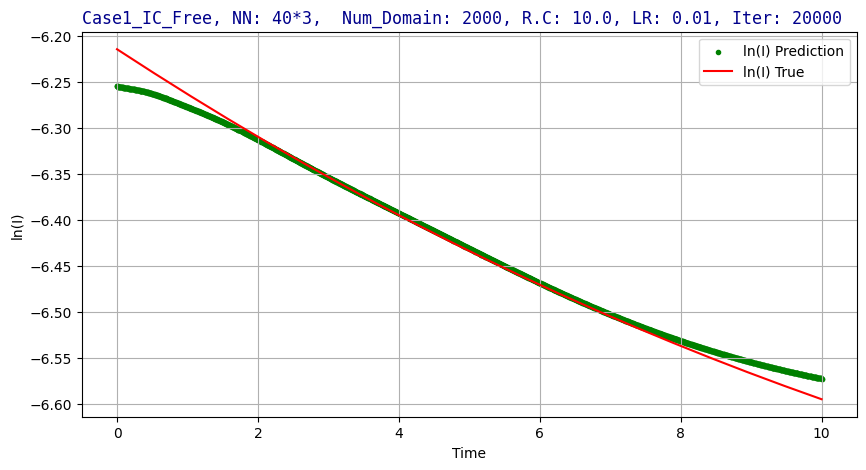

In [ ]:
#.....Ln_Case1.....#
"""Backend supported: tensorflow.compat.v1, tensorflow, pytorch, jax"""
import deepxde as dde
import numpy as np
import matplotlib.pyplot as plt
import random
import tensorflow as tf

#Set a seed for reproducibility
#seed = 0
#random.seed(seed)
#np.random.seed(seed)
#tf.random.set_seed(seed)

#Define constants.
U_dc = 1.0

#Time Limitation.
T = 10.0
N_Domain = 2000
LR = 0.01
n = 40
l = 3
ITR= 20000

#Define constants for analytical part.
R_0 = 1000.0
R_1 = 1000.0
C_1 = 0.01
m = R_1 * C_1
#Define parameters as variables.
R_r = dde.Variable(1.0)
RC = dde.Variable(1.0)

# Define the analytical solution for dI/dt + I/(RC) = 0
def analytical_solution(t, R_r, R, RC):
    return np.log((U_dc/R) * ((np.exp(-t/(RC)))) + (U_dc/R_r))


def gen_traindata():
    # Generate training data using the analytical solution
    t = np.linspace(0.0, T, 30)  # Adjust the number of points as needed
    ln_I_train = analytical_solution(t, R_0, R_1, m)

    # Return the reshaped I_train, not a commented-out variable
    return np.reshape(t,(-1,1)), np.reshape(ln_I_train,(-1,1))


# Define the Lorenz system
def Lorenz_system(t, ln_I):
    dln_I_t = dde.grad.jacobian(ln_I, t, i=0)
    return [dln_I_t + (1/(RC)*(1 - ((U_dc/R_r) * 1/(tf.exp(ln_I)))))]


geom = dde.geometry.TimeDomain(0, T)



# Get the train data
observe_t, ob_ln_I = gen_traindata()
observe_ln_I = dde.icbc.PointSetBC(observe_t, ob_ln_I[:,0:1], component=0)


data = dde.data.PDE(
    geom,
    Lorenz_system,
    [observe_ln_I],
    num_domain = N_Domain,
    anchors=observe_t,
)

net = dde.nn.FNN([1] + [n] * l + [1], "tanh", "Glorot uniform")
model = dde.Model(data, net)

external_trainable_variables = [R_r, RC]
variable = dde.callbacks.VariableValue(
    external_trainable_variables, period=600, filename="variables.dat"
)

# Train using adam
model.compile(
    "adam", lr=LR, external_trainable_variables=external_trainable_variables, metrics=['accuracy']
)
losshistory, train_state = model.train(iterations=20000, callbacks=[variable])

# Train using L-BFGS
model.compile("L-BFGS", external_trainable_variables=external_trainable_variables)
losshistory, train_state = model.train(callbacks=[variable])


# Make predictions
t_test = data.test_x
ln_I_pred = model.predict(t_test)

#Make true diagram
t_true = np.linspace(0, T, 20).reshape(-1, 1)
ln_I_train = analytical_solution(t_true, R_0, R_1, m)

# Create a single figure for all plots
plt.figure(figsize=(10, 5))

# Plot log(I) Prediction
plt.scatter(t_test, ln_I_pred, label='ln(I) Prediction', c='green' , marker='.')
# Plot log(I) True
plt.plot(t_true, ln_I_train, label='ln(I) True', c='red')


plt.xlabel('Time')
plt.ylabel('ln(I)')
plt.legend()
plt.title(f'Case1_IC_Free, NN: {n}*{l},  Num_Domain: {N_Domain}, R.C: {m}, LR: {LR}, Iter: {ITR} ', loc='left', fontdict={'family': 'monospace', 'color':  'darkblue', 'weight': 'normal', 'size': 12})
plt.grid(True)

plt.show()


In [ ]:
!cat variables.dat

0 [1.00e+00, 1.00e+00]
600 [2.09e+00, 1.92e+00]
1200 [3.14e+00, 2.91e+00]
1800 [4.12e+00, 3.87e+00]
2400 [5.07e+00, 4.82e+00]
3000 [6.04e+00, 5.79e+00]
3600 [7.03e+00, 6.79e+00]
4200 [8.06e+00, 7.84e+00]
4800 [9.15e+00, 8.94e+00]
5400 [1.03e+01, 1.01e+01]
6000 [1.15e+01, 1.13e+01]
6600 [1.28e+01, 1.26e+01]
7200 [1.42e+01, 1.40e+01]
7800 [1.56e+01, 1.55e+01]
8400 [1.71e+01, 1.70e+01]
9000 [1.87e+01, 1.86e+01]
9600 [2.04e+01, 2.03e+01]
10200 [2.21e+01, 2.20e+01]
10800 [2.39e+01, 2.38e+01]
11400 [2.57e+01, 2.57e+01]
12000 [2.76e+01, 2.76e+01]
12600 [2.96e+01, 2.96e+01]
13200 [3.16e+01, 3.16e+01]
13800 [3.37e+01, 3.37e+01]
14400 [3.58e+01, 3.58e+01]
15000 [3.79e+01, 3.79e+01]
15600 [4.02e+01, 4.01e+01]
16200 [4.24e+01, 4.24e+01]
16800 [4.48e+01, 4.47e+01]
17400 [4.72e+01, 4.71e+01]
18000 [4.96e+01, 4.95e+01]
18600 [5.22e+01, 5.20e+01]
19200 [5.48e+01, 5.46e+01]
19800 [5.74e+01, 5.72e+01]
20000 [5.83e+01, 5.81e+01]
20000 [5.83e+01, 5.81e+01]
20239 [9.91e+02, 9.04e+02]


In [ ]:
# Load optimized values from the file
with open("variables.dat", "r") as file:
    lines = file.readlines()

# Extract the values from the last line
last_line_values = lines[-1].split("[")[1].split("]")[0].split(",")
R_r_p, RC_p = map(float, last_line_values)

# Predict the current at t=0
ln_I_pred_at_t0 = model.predict(np.array([[0.0]]))

# Convert ln(I) to I using the inverse of the natural logarithm
I_pred_at_t0 = np.exp(ln_I_pred_at_t0)

# Print the predicted current at t=0
print(f'Predicted I at t=0: {I_pred_at_t0[0,0]}')
# Calculate R_T using the predicted current at t=0
R_T_pred = U_dc / I_pred_at_t0[0, 0]

# Calculate R_p using the R_T and the predicted R_r_p
R_pred = (R_r_p * R_T_pred)/(R_r_p - R_T_pred)

# Print the calculated resistance at t=0
print(f'Calculated R at t=0: {R_pred}')

# Assuming T is a constant defined earlier in your code
T = RC_p

# Calculate C using the calculated resistance and time constant
C_pred = T / R_pred

# Print the calculated capacitance
print(f'Calculated C: {C_pred}')

Predicted I at t=0: 0.0019210317404940724
Calculated R at t=0: 1096.551340156775
Calculated C: 0.8244028044056325


Case0,
Training Data : Measurments Data,
IC-Free.




In [ ]:
!pip -q install deepxde

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.3/172.3 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.3/100.3 kB 6.8 MB/s eta 0:00:00


Compiling model...
Building feed-forward neural network...
'build' took 0.079780 s



/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 0.407469 s

Training model...

Step      Train loss              Test loss               Test metric   
0         [1.00e+00, 6.31e+00]    [1.00e+00, 6.31e+00]    [1.00e+00]    
1000      [1.82e-02, 1.61e+00]    [1.82e-02, 1.61e+00]    [1.00e+00]    
2000      [8.15e-03, 1.61e+00]    [8.15e-03, 1.61e+00]    [1.00e+00]    
3000      [4.75e-03, 1.61e+00]    [4.75e-03, 1.61e+00]    [1.00e+00]    
4000      [3.05e-03, 1.61e+00]    [3.05e-03, 1.61e+00]    [1.00e+00]    
5000      [2.06e-03, 1.61e+00]    [2.06e-03, 1.61e+00]    [1.00e+00]    
6000      [1.42e-03, 1.61e+00]    [1.42e-03, 1.61e+00]    [1.00e+00]    
7000      [1.00e-03, 1.61e+00]    [1.00e-03, 1.61e+00]    [1.00e+00]    
8000      [7.08e-04, 1.61e+00]    [7.08e-04, 1.61e+00]    [1.00e+00]    
9000      [5.04e-04, 1.61e+00]    [5.04e-04, 1.61e+00]    [1.00e+00]    
10000     [3.60e-04, 1.61e+00]    [3.60e-04, 1.61e+00]    [1.00e+00]    
11000     [2.57e-04, 1.61e+00]    [2.57e-04, 1.61e+00]    [1.00e+00]    
12000

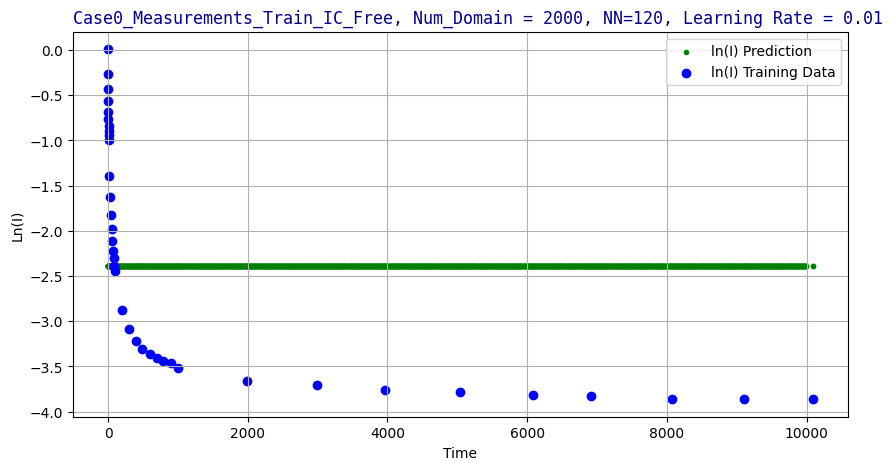

In [ ]:
#.....Ln_Case0.....IC_free#
"""Backend supported: tensorflow.compat.v1, tensorflow, pytorch, jax"""
import deepxde as dde
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import tensorflow as tf

#seed = 0
#random.seed(seed)
#np.random.seed(seed)
#tf.random.set_seed(seed)

#Define constants.
U_dc = 1.0

#Time Limitation.
T = 10000.0
N_Domain = 2000
LR = 0.01

#Define parameters as variables.
R = dde.Variable(1.0)
C = dde.Variable(1.0)
#Define number of nodes and layers of NN.
n=40
l=3

array1 = np.array([1, 1.985873504, 2.971653338, 4.011916777, 4.971206812, 5.952153859, 6.945654867, 8.035779515, 9.060859, 10.04297213, 19.94407226,29.84423166, 39.60640468, 49.92569147, 58.76078126 ,69.75501826, 78.65330965, 89.45054065 ,100.8612462, 200.2976765, 302.3062197, 397.7658488, 492.8755967, 595.2155128, 706.5809945, 789.9126601, 898.3489039, 1004.296999, 1994.406801, 2984.423802, 3960.639623, 5035.567461, 6081.139607, 6915.935617, 8070.309252, 9099.797382, 10086.12677])
array2 = np.array([1.01E-12, 7.66E-13, 6.51E-13, 5.67E-13, 5.07E-13, 4.66E-13, 4.31E-13, 4.09E-13, 3.92E-13, 3.69E-13, 2.49E-13, 1.96E-13, 1.61E-13, 1.38E-13, 1.21E-13, 1.08E-13, 1.00E-13, 9.13E-14, 8.67E-14, 5.64E-14, 4.59E-14, 4.00E-14, 3.67E-14, 3.46E-14, 3.31E-14, 3.20E-14, 3.12E-14, 2.96E-14, 2.56E-14, 2.45E-14, 2.33E-14,2.27E-14, 2.21E-14, 2.17E-14, 2.11E-14, 2.10E-14, 2.10E-14])


Data = pd.DataFrame({'t': array1, 'Ln_I': np.log(array2*10**12)})

def gen_traindata():
    return Data["t"], Data["Ln_I"]



# Define the Lorenz system
def Lorenz_system(t, ln_I):
    dln_I_t = dde.grad.jacobian(ln_I, t, i=0)
    return [dln_I_t + 1 / (R * C)]



geom = dde.geometry.TimeDomain(0, T)



# Get the train data
observe_t, ob_Ln_I = gen_traindata()
observe_t = observe_t.values.reshape(-1, 1)
observe_Ln_I = dde.icbc.PointSetBC(observe_t, ob_Ln_I, component=0)


data = dde.data.PDE(
    geom,
    Lorenz_system,
    [observe_Ln_I],
    num_domain=N_Domain,
    anchors=observe_t,
)
net = dde.nn.FNN([1] + [n] * l + [1], "tanh", "Glorot uniform")
model = dde.Model(data, net)

external_trainable_variables = [R, C]
variable = dde.callbacks.VariableValue(
    external_trainable_variables, period=600, filename="variables.dat"
)

# Train using adam
model.compile(
    "adam", lr=LR, external_trainable_variables=external_trainable_variables, metrics=['accuracy'])
losshistory, train_state = model.train(iterations=20000, callbacks=[variable])

# Train using L-BFGS
model.compile("L-BFGS", external_trainable_variables=external_trainable_variables)
losshistory, train_state = model.train(callbacks=[variable])


# Make predictions
t_test = data.test_x
ln_I_pred = model.predict(t_test)



# Create a single figure for all plots
plt.figure(figsize=(10, 5))

# Plot log(I) Prediction
plt.scatter(t_test, ln_I_pred, label='ln(I) Prediction', c='green' , marker='.')
# Plot log(I) True
plt.scatter(observe_t, ob_Ln_I, label='ln(I) Training Data', c='blue', marker='o')



plt.xlabel('Time')
plt.ylabel('Ln(I)')
plt.legend()
plt.title(f'Case0_Measurements_Train_IC_Free, Num_Domain = {N_Domain}, NN={n*l}, Learning Rate = {LR}', loc='left', fontdict={'family': 'monospace', 'color':  'darkblue', 'weight': 'normal', 'size': 12})
plt.grid(True)

plt.show()


In [ ]:
!cat variables.dat

0 [1.00e+00, 1.00e+00]
600 [2.38e+00, 2.38e+00]
1200 [2.86e+00, 2.86e+00]
1800 [3.22e+00, 3.22e+00]
2400 [3.53e+00, 3.53e+00]
3000 [3.81e+00, 3.81e+00]
3600 [4.08e+00, 4.08e+00]
4200 [4.34e+00, 4.34e+00]
4800 [4.61e+00, 4.61e+00]
5400 [4.87e+00, 4.87e+00]
6000 [5.15e+00, 5.15e+00]
6600 [5.43e+00, 5.43e+00]
7200 [5.72e+00, 5.72e+00]
7800 [6.03e+00, 6.03e+00]
8400 [6.34e+00, 6.34e+00]
9000 [6.67e+00, 6.67e+00]
9600 [7.02e+00, 7.02e+00]
10200 [7.38e+00, 7.38e+00]
10800 [7.76e+00, 7.76e+00]
11400 [8.16e+00, 8.16e+00]
12000 [8.58e+00, 8.58e+00]
12600 [9.02e+00, 9.02e+00]
13200 [9.48e+00, 9.48e+00]
13800 [9.97e+00, 9.97e+00]
14400 [1.05e+01, 1.05e+01]
15000 [1.10e+01, 1.10e+01]
15600 [1.16e+01, 1.16e+01]
16200 [1.22e+01, 1.22e+01]
16800 [1.28e+01, 1.28e+01]
17400 [1.34e+01, 1.34e+01]
18000 [1.41e+01, 1.41e+01]
18600 [1.48e+01, 1.48e+01]
19200 [1.56e+01, 1.56e+01]
19800 [1.64e+01, 1.64e+01]
20000 [1.66e+01, 1.66e+01]
20000 [1.66e+01, 1.66e+01]
20011 [1.66e+01, 1.66e+01]


In [ ]:
!pip -q install deepxde

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.2/166.2 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.3/100.3 kB 11.2 MB/s eta 0:00:00


Case0,
Training Data : Measurments Data,
IC : log(U_dc / R)
highest_density.

Compiling model...
Building feed-forward neural network...
'build' took 0.061432 s



/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 0.504494 s

Training model...

Step      Train loss                        Test loss                         Test metric
0         [1.00e+00, nan, 8.96e+02]         [1.00e+00, nan, 8.96e+02]         []  

Best model at step 0:
  train loss: inf
  test loss: inf
  test metric: 

'train' took 0.670546 s

Compiling model...
'compile' took 0.435067 s

Training model...

Step      Train loss                        Test loss                         Test metric
1         [9.60e-01, nan, 7.48e+02]         [9.60e-01, nan, 7.48e+02]         []  
1000      [1.01e-04, nan, 1.12e-04]         [1.01e-04, nan, 1.12e-04]             
2000      [8.87e-05, nan, 6.42e-05]         [8.87e-05, nan, 6.42e-05]             
3000      [7.46e-05, nan, 5.39e-05]         [7.46e-05, nan, 5.39e-05]             
4000      [6.52e-05, nan, 4.36e-05]         [6.52e-05, nan, 4.36e-05]             
5000      [6.45e-05, nan, 4.37e-05]         [6.45e-05, nan, 4.37e-05]             
6000      [6.34e-05, nan, 4.

NameError: ignored

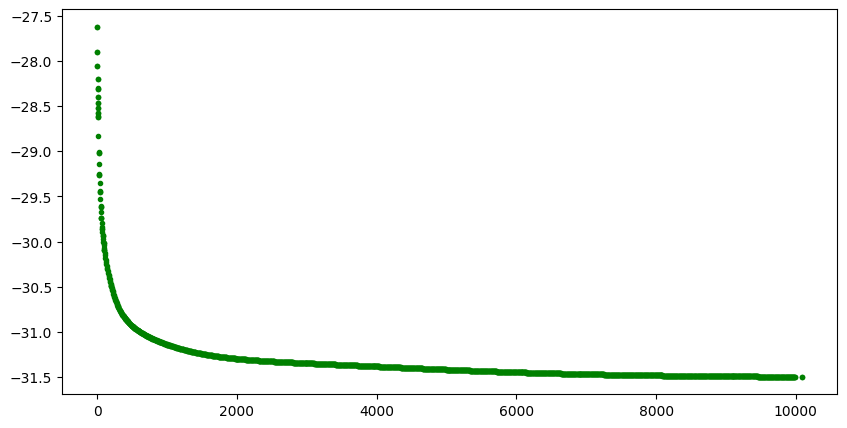

In [ ]:
#.....Ln_Case0_highest_density.....#
"""Backend supported: tensorflow.compat.v1, tensorflow, pytorch, jax"""
import deepxde as dde
import numpy as np
import matplotlib.pyplot as plt
import random
import tensorflow as tf

seed = 0
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

#Define constants.
U_dc = 1.0

#Time Limitation.
T = 10000.0
N_Domain = 2000
LR = 0.01
#Define constants for analytical part.
R_0 = 1000.0
C_0 = 0.01
n = R_0*C_0
#Define parameters as variables.
R = dde.Variable(1.0)
C = dde.Variable(1.0)
import numpy as np
import pandas as pd

array1 = np.array([1, 1.985873504, 2.971653338, 4.011916777, 4.971206812, 5.952153859, 6.945654867, 8.035779515, 9.060859, 10.04297213, 19.94407226,29.84423166, 39.60640468, 49.92569147, 58.76078126 ,69.75501826, 78.65330965, 89.45054065 ,100.8612462, 200.2976765, 302.3062197, 397.7658488, 492.8755967, 595.2155128, 706.5809945, 789.9126601, 898.3489039, 1004.296999, 1994.406801, 2984.423802, 3960.639623, 5035.567461, 6081.139607, 6915.935617, 8070.309252, 9099.797382, 10086.12677])
array2 = np.array([1.01E-12, 7.66E-13, 6.51E-13, 5.67E-13, 5.07E-13, 4.66E-13, 4.31E-13, 4.09E-13, 3.92E-13, 3.69E-13, 2.49E-13, 1.96E-13, 1.61E-13, 1.38E-13, 1.21E-13, 1.08E-13, 1.00E-13, 9.13E-14, 8.67E-14, 5.64E-14, 4.59E-14, 4.00E-14, 3.67E-14, 3.46E-14, 3.31E-14, 3.20E-14, 3.12E-14, 2.96E-14, 2.56E-14, 2.45E-14, 2.33E-14,2.27E-14, 2.21E-14, 2.17E-14, 2.11E-14, 2.10E-14, 2.10E-14])
#array2_numeric = pd.to_numeric(array2, errors='coerce')
#array2_m = array2 *10**12

Data = pd.DataFrame({'t': array1, 'Ln_I': np.log(array2)})


def gen_traindata():
    return np.reshape(Data['t'].values,(-1,1)), np.reshape(Data["Ln_I"].values,(-1,1))



# Define the Lorenz system
def Lorenz_system(t, ln_I):
    dln_I_t = dde.grad.jacobian(ln_I, t, i=0)
    return [dln_I_t + 1 / (R * C)]

def boundary(_, on_initial):
    return on_initial

geom = dde.geometry.TimeDomain(0, T)

# Initial conditions
ic0 = dde.icbc.IC(geom, lambda X : tf.math.log(U_dc / R) , boundary, component=0)


# Get the train data
observe_t, ob_Ln_I = gen_traindata()
observe_Ln_I = dde.icbc.PointSetBC(observe_t, ob_Ln_I, component=0)


data = dde.data.PDE(
    geom,
    Lorenz_system,
    [ic0, observe_Ln_I],
    num_domain=N_Domain,
    num_boundary=0,
    anchors=observe_t,
)

net = dde.nn.FNN([1] + [40] * 3 + [1], "tanh", "Glorot uniform")
model = dde.Model(data, net)

external_trainable_variables = [R, C]
variable = dde.callbacks.VariableValue(
    external_trainable_variables, period=600, filename="variables.dat"
)

# Train using adam
model.compile(
    "adam", lr=LR, external_trainable_variables=external_trainable_variables
)
losshistory, train_state = model.train(iterations=20000, callbacks=[variable])

# Train using L-BFGS
model.compile("L-BFGS", external_trainable_variables=external_trainable_variables)
losshistory, train_state = model.train(callbacks=[variable])


# Make predictions
t_test = data.test_x
ln_I_pred = model.predict(t_test)



# Create a single figure for all plots
plt.figure(figsize=(10, 5))

# Plot log(I) Prediction
plt.scatter(t_test, ln_I_pred, label='ln(I) Prediction', c='green' , marker='.')
# Plot log(I) True
plt.scatter(observe_t, ob_ln_I, label='ln(I) Training Data', c='blue', marker='o')



plt.xlabel('Time')
plt.ylabel('Ln(I)')
plt.legend()
plt.title(f'Case0_Measurements_train_IC, Num_Domain = {N_Domain}, R.C={n}, Learning Rate = {LR}', loc='left', fontdict={'family': 'monospace', 'color':  'darkblue', 'weight': 'normal', 'size': 12})
plt.grid(True)

plt.show()



In [ ]:
!pip -q install deepxde

Compiling model...
Building feed-forward neural network...
'build' took 0.047384 s



/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 0.674601 s

Training model...

Step      Train loss                        Test loss                         Test metric
0         [1.00e+00, nan, 9.68e+02]         [1.00e+00, nan, 9.68e+02]         []  

Best model at step 0:
  train loss: inf
  test loss: inf
  test metric: 

'train' took 2.264320 s

Compiling model...
'compile' took 0.786194 s

Training model...

Step      Train loss                        Test loss                         Test metric
1         [9.60e-01, nan, 8.06e+02]         [9.60e-01, nan, 8.06e+02]         []  
1000      [1.81e-04, nan, 1.61e-04]         [1.81e-04, nan, 1.61e-04]             
2000      [1.36e-04, nan, 1.20e-04]         [1.36e-04, nan, 1.20e-04]             
3000      [1.33e-04, nan, 9.56e-05]         [1.33e-04, nan, 9.56e-05]             
4000      [7.48e-05, nan, 8.84e-05]         [7.48e-05, nan, 8.84e-05]             
5000      [5.66e-05, nan, 8.20e-05]         [5.66e-05, nan, 8.20e-05]             
6000      [4.83e-05, nan, 8.

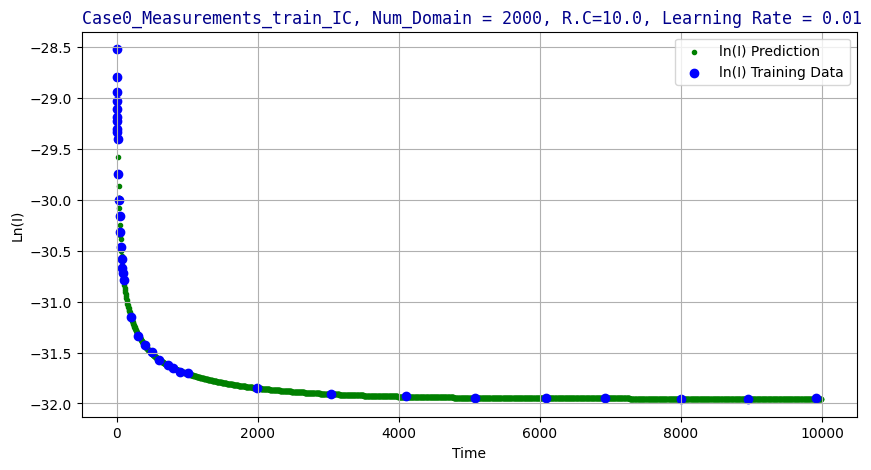

In [ ]:
#.....Ln_Case0_Middel_density.....#
"""Backend supported: tensorflow.compat.v1, tensorflow, pytorch, jax"""
import deepxde as dde
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import tensorflow as tf

seed = 0
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

#Define constants.
U_dc = 1.0

#Time Limitation.
T = 10000.0
N_Domain = 2000
LR = 0.01
#Define constants for analytical part.
R_0 = 1000.0
C_0 = 0.01
n = R_0*C_0
#Define parameters as variables.
R = dde.Variable(1.0)
C = dde.Variable(1.0)
import numpy as np
import pandas as pd

array1 = np.array([1, 2.002977192, 2.997247229, 4.011916777, 4.971206812, 6.00341784, 6.886344999, 8.035779515, 8.906779734, 10.04297213, 19.94407226, 29.58938781, 38.93288397, 50.35568534, 58.76078126, 69.75501826, 79.33072523, 88.68671063, 100.8612462, 200.2976765, 302.3062197, 397.7658488, 497.1205752, 600.3419119, 718.8045157, 796.715923, 890.6777835, 1012.946685, 1994.406801, 3036.05294, 4098.85937, 5078.937178, 6081.139607, 6915.935617, 8001.395811, 8945.052158, 9914.60867])
array2 = np.array([4.11E-13, 3.12E-13, 2.70E-13, 2.48E-13, 2.29E-13, 2.12E-13, 2.03E-13, 1.88E-13, 1.83E-13, 1.70E-13, 1.21E-13, 9.38E-14, 7.97E-14, 6.83E-14, 5.86E-14, 5.24E-14, 4.81E-14, 4.57E-14, 4.26E-14, 2.97E-14, 2.46E-14, 2.24E-14, 2.09E-14, 1.95E-14, 1.85E-14, 1.79E-14, 1.73E-14, 1.70E-14, 1.47E-14, 1.39E-14, 1.36E-14, 1.33E-14, 1.34E-14, 1.34E-14, 1.32E-14, 1.32E-14, 1.33E-14])
#array2_numeric = pd.to_numeric(array2, errors='coerce')
#array2_m = array2 *10**12

Data = pd.DataFrame({'t': array1, 'Ln_I': np.log(array2)})


def gen_traindata():
    return np.reshape(Data['t'].values,(-1,1)), np.reshape(Data["Ln_I"].values,(-1,1))



# Define the Lorenz system
def Lorenz_system(t, ln_I):
    dln_I_t = dde.grad.jacobian(ln_I, t, i=0)
    return [dln_I_t + 1 / (R * C)]

def boundary(_, on_initial):
    return on_initial

geom = dde.geometry.TimeDomain(0, T)

# Initial conditions
ic0 = dde.icbc.IC(geom, lambda X : tf.math.log(U_dc / R) , boundary, component=0)


# Get the train data
observe_t, ob_Ln_I = gen_traindata()
observe_Ln_I = dde.icbc.PointSetBC(observe_t, ob_Ln_I, component=0)


data = dde.data.PDE(
    geom,
    Lorenz_system,
    [ic0, observe_Ln_I],
    num_domain=N_Domain,
    num_boundary=0,
    anchors=observe_t,
)

net = dde.nn.FNN([1] + [40] * 3 + [1], "tanh", "Glorot uniform")
model = dde.Model(data, net)

external_trainable_variables = [R, C]
variable = dde.callbacks.VariableValue(
    external_trainable_variables, period=600, filename="variables.dat"
)

# Train using adam
model.compile(
    "adam", lr=LR, external_trainable_variables=external_trainable_variables
)
losshistory, train_state = model.train(iterations=20000, callbacks=[variable])

# Train using L-BFGS
model.compile("L-BFGS", external_trainable_variables=external_trainable_variables)
losshistory, train_state = model.train(callbacks=[variable])


# Make predictions
t_test = data.test_x
ln_I_pred = model.predict(t_test)



# Create a single figure for all plots
plt.figure(figsize=(10, 5))

# Plot log(I) Prediction
plt.scatter(t_test, ln_I_pred, label='ln(I) Prediction', c='green' , marker='.')
# Plot log(I) True
plt.scatter(observe_t, ob_Ln_I, label='ln(I) Training Data', c='blue', marker='o')



plt.xlabel('Time')
plt.ylabel('Ln(I)')
plt.legend()
plt.title(f'Case0_Measurements_train_IC, Num_Domain = {N_Domain}, R.C={n}, Learning Rate = {LR}', loc='left', fontdict={'family': 'monospace', 'color':  'darkblue', 'weight': 'normal', 'size': 12})
plt.grid(True)

plt.show()



In [ ]:
np.log(4.11E-13)

Compiling model...
Building feed-forward neural network...
'build' took 0.050459 s



/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 0.752146 s

Training model...

Step      Train loss                        Test loss                         Test metric
0         [1.00e+00, nan, 9.68e+02]         [1.00e+00, nan, 9.68e+02]         []  

Best model at step 0:
  train loss: inf
  test loss: inf
  test metric: 

'train' took 3.229469 s

Compiling model...
'compile' took 0.902286 s

Training model...

Step      Train loss                        Test loss                         Test metric
1         [9.60e-01, nan, 8.06e+02]         [9.60e-01, nan, 8.06e+02]         []  
1000      [2.20e-04, nan, 1.23e-04]         [2.20e-04, nan, 1.23e-04]             
2000      [1.15e-04, nan, 1.15e-04]         [1.15e-04, nan, 1.15e-04]             
3000      [9.77e-05, nan, 9.41e-05]         [9.77e-05, nan, 9.41e-05]             
4000      [6.74e-05, nan, 8.66e-05]         [6.74e-05, nan, 8.66e-05]             
5000      [5.04e-05, nan, 7.66e-05]         [5.04e-05, nan, 7.66e-05]             
6000      [4.50e-05, nan, 7.

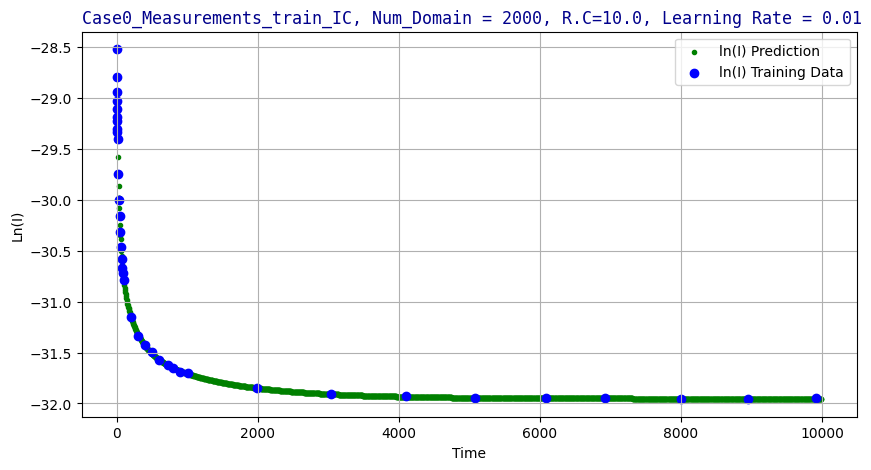

In [ ]:
#.....Ln_Case0_Middel_density.....#
"""Backend supported: tensorflow.compat.v1, tensorflow, pytorch, jax"""
import deepxde as dde
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import tensorflow as tf

seed = 0
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

#Define constants.
U_dc = 1.0

#Time Limitation.
T = 10000.0
N_Domain = 2000
LR = 0.01
#Define constants for analytical part.
R_0 = 1000.0
C_0 = 0.01
n = R_0*C_0
#Define parameters as variables.
R = dde.Variable(1.0)
C = dde.Variable(1.0)
import numpy as np
import pandas as pd

array1 = np.array([1, 2.002977192, 2.997247229, 4.011916777, 4.971206812, 6.00341784, 6.886344999, 8.035779515, 8.906779734, 10.04297213, 19.94407226, 29.58938781, 38.93288397, 50.35568534, 58.76078126, 69.75501826, 79.33072523, 88.68671063, 100.8612462, 200.2976765, 302.3062197, 397.7658488, 497.1205752, 600.3419119, 718.8045157, 796.715923, 890.6777835, 1012.946685, 1994.406801, 3036.05294, 4098.85937, 5078.937178, 6081.139607, 6915.935617, 8001.395811, 8945.052158, 9914.60867])
array2 = np.array([4.11E-13, 3.12E-13, 2.70E-13, 2.48E-13, 2.29E-13, 2.12E-13, 2.03E-13, 1.88E-13, 1.83E-13, 1.70E-13, 1.21E-13, 9.38E-14, 7.97E-14, 6.83E-14, 5.86E-14, 5.24E-14, 4.81E-14, 4.57E-14, 4.26E-14, 2.97E-14, 2.46E-14, 2.24E-14, 2.09E-14, 1.95E-14, 1.85E-14, 1.79E-14, 1.73E-14, 1.70E-14, 1.47E-14, 1.39E-14, 1.36E-14, 1.33E-14, 1.34E-14, 1.34E-14, 1.32E-14, 1.32E-14, 1.33E-14])
#array2_numeric = pd.to_numeric(array2, errors='coerce')
#array2_m = array2 *10**12

Data = pd.DataFrame({'t': array1, 'Ln_I': np.log(array2)})


def gen_traindata():
    return np.reshape(Data['t'].values,(-1,1)), np.reshape(Data["Ln_I"].values,(-1,1))



# Define the Lorenz system
def Lorenz_system(t, ln_I):
    dln_I_t = dde.grad.jacobian(ln_I, t, i=0)
    return [dln_I_t + 1 / (R * C)]

def boundary(_, on_initial):
    return on_initial

geom = dde.geometry.TimeDomain(0, T)

# Initial conditions
ic0 = dde.icbc.IC(geom, lambda X : tf.math.log(U_dc / R) , boundary, component=0)


# Get the train data
observe_t, ob_Ln_I = gen_traindata()
observe_Ln_I = dde.icbc.PointSetBC(observe_t, ob_Ln_I, component=0)


data = dde.data.PDE(
    geom,
    Lorenz_system,
    [ic0, observe_Ln_I],
    num_domain=N_Domain,
    num_boundary=0,
    anchors=observe_t,
)

net = dde.nn.FNN([1] + [40] * 3 + [1], "tanh", "Glorot uniform")
model = dde.Model(data, net)

external_trainable_variables = [R, C]
variable = dde.callbacks.VariableValue(
    external_trainable_variables, period=600, filename="variables.dat"
)

# Train using adam
model.compile(
    "adam", lr=LR, external_trainable_variables=external_trainable_variables, metrics=['accuracy']
)
losshistory, train_state = model.train(iterations=20000, callbacks=[variable])

# Train using L-BFGS
model.compile("L-BFGS", external_trainable_variables=external_trainable_variables)
losshistory, train_state = model.train(callbacks=[variable])


# Make predictions
t_test = data.test_x
ln_I_pred = model.predict(t_test)



# Create a single figure for all plots
plt.figure(figsize=(10, 5))

# Plot log(I) Prediction
plt.scatter(t_test, ln_I_pred, label='ln(I) Prediction', c='green' , marker='.')
# Plot log(I) True
plt.scatter(observe_t, ob_Ln_I, label='ln(I) Training Data', c='blue', marker='o')



plt.xlabel('Time')
plt.ylabel('Ln(I)')
plt.legend()
plt.title(f'Case0_Measurements_train_IC, Num_Domain = {N_Domain}, R.C={n}, Learning Rate = {LR}', loc='left', fontdict={'family': 'monospace', 'color':  'darkblue', 'weight': 'normal', 'size': 12})
plt.grid(True)

plt.show()



In [ ]:
!pip -q install deepxde

Compiling model...
Building feed-forward neural network...
'build' took 0.046757 s



/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 0.418165 s

Training model...

Step      Train loss                        Test loss                         Test metric
0         [1.00e+00, nan, 9.63e+02]         [1.00e+00, nan, 9.63e+02]         []  

Best model at step 0:
  train loss: inf
  test loss: inf
  test metric: 

'train' took 0.619580 s

Compiling model...
'compile' took 0.379313 s

Training model...

Step      Train loss                        Test loss                         Test metric
1         [9.60e-01, nan, 8.38e+02]         [9.60e-01, nan, 8.38e+02]         []  
1000      [3.63e-04, nan, 3.97e-04]         [3.63e-04, nan, 3.97e-04]             
2000      [1.77e-04, nan, 7.48e-05]         [1.77e-04, nan, 7.48e-05]             
3000      [1.15e-04, nan, 6.02e-05]         [1.15e-04, nan, 6.02e-05]             
4000      [1.01e-04, nan, 4.57e-05]         [1.01e-04, nan, 4.57e-05]             
5000      [8.26e-05, nan, 4.45e-05]         [8.26e-05, nan, 4.45e-05]             
6000      [7.59e-05, nan, 4.

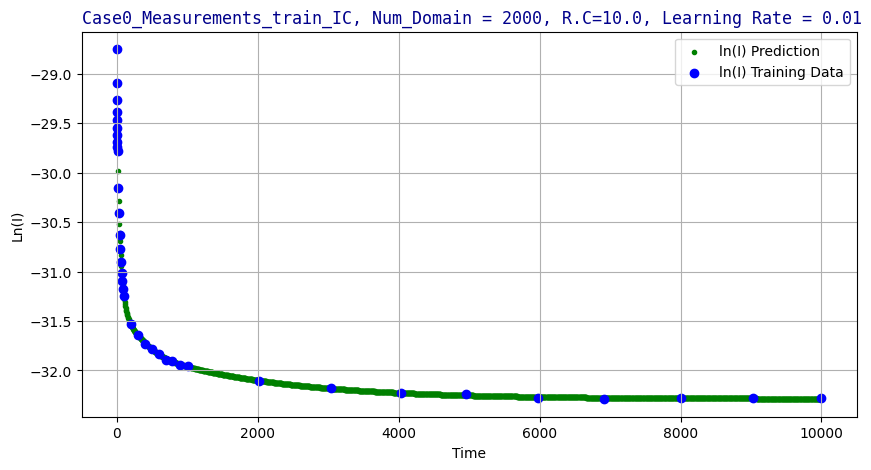

In [ ]:
-#.....Ln_Case0_lowest_density.....#
"""Backend supported: tensorflow.compat.v1, tensorflow, pytorch, jax"""
import deepxde as dde
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import tensorflow as tf

seed = 0
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

#Define constants.
U_dc = 1.0

#Time Limitation.
T = 10000.0
N_Domain = 2000
LR = 0.01
#Define constants for analytical part.
R_0 = 1000.0
C_0 = 0.01
n = R_0*C_0
#Define parameters as variables.
R = dde.Variable(1.0)
C = dde.Variable(1.0)

array1 = np.array([0.991460867, 1.985873504, 2.971653338, 3.977659336, 5.014022212, 6.00341784, 6.945654867, 7.967160928, 8.983490954, 9.957213861, 19.77376719, 29.58938781, 39.94752186, 49.49936937, 59.26686891, 70.35579573, 80.01394106, 90.22091083, 100.0000213, 198.5873081, 302.3062197, 404.6470122, 497.1205752, 600.3419119, 700.5474058, 783.1674912, 898.3489039, 1004.296999, 2011.583983, 3036.05294, 4029.156839, 4949.935882, 5977.732807, 6915.935617, 8001.395811, 9022.093006, 10000])
array2 = np.array([3.26E-13, 2.31E-13, 1.95E-13, 1.73E-13, 1.60E-13, 1.47E-13, 1.37E-13, 1.27E-13, 1.21E-13, 1.16E-13, 7.98E-14, 6.22E-14, 4.98E-14, 4.31E-14, 3.79E-14, 3.39E-14, 3.13E-14, 2.88E-14, 2.69E-14, 2.02E-14, 1.81E-14, 1.65E-14, 1.58E-14, 1.50E-14, 1.41E-14, 1.40E-14, 1.34E-14, 1.32E-14, 1.14E-14, 1.06E-14, 1.01E-14, 9.97E-15, 9.63E-15, 9.47E-15, 9.55E-15, 9.55E-15, 9.63E-15])
#array2_numeric = pd.to_numeric(array2, errors='coerce')
#array2_m = array2 *10**12

Data = pd.DataFrame({'t': array1, 'Ln_I': np.log(array2)})


def gen_traindata():
    return np.reshape(Data['t'].values,(-1,1)), np.reshape(Data["Ln_I"].values,(-1,1))



# Define the Lorenz system
def Lorenz_system(t, ln_I):
    dln_I_t = dde.grad.jacobian(ln_I, t, i=0)
    return [dln_I_t + 1 / (R * C)]

def boundary(_, on_initial):
    return on_initial

geom = dde.geometry.TimeDomain(0, T)

# Initial conditions
ic0 = dde.icbc.IC(geom, lambda X : tf.math.log(U_dc / R) , boundary, component=0)


# Get the train data
observe_t, ob_Ln_I = gen_traindata()
observe_Ln_I = dde.icbc.PointSetBC(observe_t, ob_Ln_I, component=0)


data = dde.data.PDE(
    geom,
    Lorenz_system,
    [ic0, observe_Ln_I],
    num_domain=N_Domain,
    num_boundary=0,
    anchors=observe_t,
)

net = dde.nn.FNN([1] + [40] * 3 + [1], "tanh", "Glorot uniform")
model = dde.Model(data, net)

external_trainable_variables = [R, C]
variable = dde.callbacks.VariableValue(
    external_trainable_variables, period=600, filename="variables.dat"
)

# Train using adam
model.compile(
    "adam", lr=LR, external_trainable_variables=external_trainable_variables
)
losshistory, train_state = model.train(iterations=20000, callbacks=[variable])

# Train using L-BFGS
model.compile("L-BFGS", external_trainable_variables=external_trainable_variables)
losshistory, train_state = model.train(callbacks=[variable])


# Make predictions
t_test = data.test_x
ln_I_pred = model.predict(t_test)



# Create a single figure for all plots
plt.figure(figsize=(10, 5))

# Plot log(I) Prediction
plt.scatter(t_test, ln_I_pred, label='ln(I) Prediction', c='green' , marker='.')
# Plot log(I) True
plt.scatter(observe_t, ob_Ln_I, label='ln(I) Training Data', c='blue', marker='o')



plt.xlabel('Time')
plt.ylabel('Ln(I)')
plt.legend()
plt.title(f'Case0_Measurements_train_IC, Num_Domain = {N_Domain}, R.C={n}, Learning Rate = {LR}', loc='left', fontdict={'family': 'monospace', 'color':  'darkblue', 'weight': 'normal', 'size': 12})
plt.grid(True)

plt.show()



Case1,
Training Data : Measurments Data,
IC : log(U_dc( 1/ Rr + 1/R))
highest_density.

In [ ]:
!pip -q install deepxde

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.3/172.3 kB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.3/100.3 kB 8.7 MB/s eta 0:00:00


No backend selected.
Finding available backend...


Using backend: tensorflow.compat.v1
Other supported backends: tensorflow, pytorch, jax, paddle.
paddle supports more examples now and is recommended.
Instructions for updating:
non-resource variables are not supported in the long term


Found tensorflow.compat.v1
Setting the default backend to "tensorflow.compat.v1". You can change it in the ~/.deepxde/config.json file or export the DDE_BACKEND environment variable. Valid options are: tensorflow.compat.v1, tensorflow, pytorch, jax, paddle (all lowercase)
Compiling model...
Building feed-forward neural network...
'build' took 0.081429 s



/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 0.585531 s

Training model...

Step      Train loss                        Test loss                         Test metric
0         [1.33e-01, nan, 2.45e+00]         [1.33e-01, nan, 2.45e+00]         []  

Best model at step 0:
  train loss: inf
  test loss: inf
  test metric: 

'train' took 0.493150 s

Compiling model...
'compile' took 0.273381 s

Training model...

Step      Train loss                        Test loss                         Test metric
1         [3.63e-02, nan, 2.20e+00]         [3.63e-02, nan, 2.20e+00]         []  
1000      [4.53e-03, nan, 3.41e-03]         [4.53e-03, nan, 3.41e-03]             
2000      [1.01e-03, nan, 1.11e-03]         [1.01e-03, nan, 1.11e-03]             
3000      [1.74e-04, nan, 6.18e-04]         [1.74e-04, nan, 6.18e-04]             
4000      [1.78e-04, nan, 5.17e-04]         [1.78e-04, nan, 5.17e-04]             
5000      [1.45e-04, nan, 4.88e-04]         [1.45e-04, nan, 4.88e-04]             
6000      [1.45e-04, nan, 4.

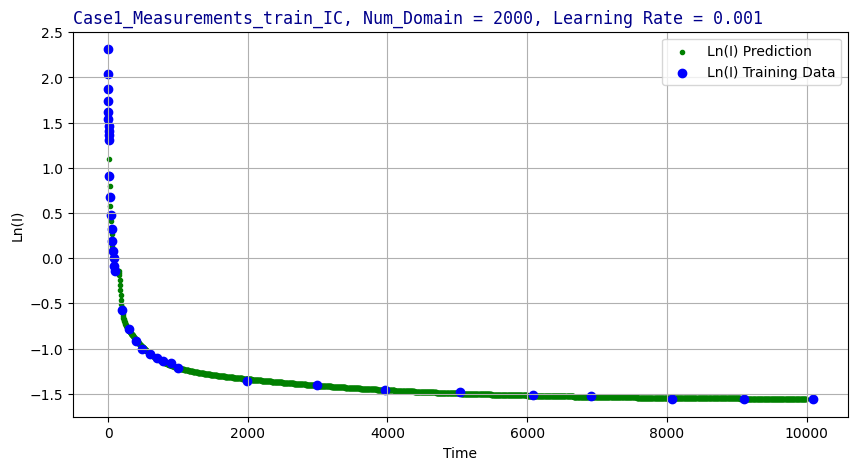

In [ ]:
#.....Ln_Case1_highest_density.....#
"""Backend supported: tensorflow.compat.v1, tensorflow, pytorch, jax"""
import deepxde as dde
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import tensorflow as tf

seed = 0
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

#Define constants.
U_dc = 1

#Time Limitation.
T = 10000.0
N_Domain = 2000
LR = 0.001

#Define parameters as variables.
Rr = dde.Variable(1.0)
R = dde.Variable(1.0)
C = dde.Variable(1.0)

#MeasurmentsI Data Frame.
array1 = np.array([1, 1.985873504, 2.971653338, 4.011916777, 4.971206812, 5.952153859, 6.945654867, 8.035779515, 9.060859, 10.04297213, 19.94407226,29.84423166, 39.60640468, 49.92569147, 58.76078126 ,69.75501826, 78.65330965, 89.45054065 ,100.8612462, 200.2976765, 302.3062197, 397.7658488, 492.8755967, 595.2155128, 706.5809945, 789.9126601, 898.3489039, 1004.296999, 1994.406801, 2984.423802, 3960.639623, 5035.567461, 6081.139607, 6915.935617, 8070.309252, 9099.797382, 10086.12677])
array2 = np.array([1.01E-12, 7.66E-13, 6.51E-13, 5.67E-13, 5.07E-13, 4.66E-13, 4.31E-13, 4.09E-13, 3.92E-13, 3.69E-13, 2.49E-13, 1.96E-13, 1.61E-13, 1.38E-13, 1.21E-13, 1.08E-13, 1.00E-13, 9.13E-14, 8.67E-14, 5.64E-14, 4.59E-14, 4.00E-14, 3.67E-14, 3.46E-14, 3.31E-14, 3.20E-14, 3.12E-14, 2.96E-14, 2.56E-14, 2.45E-14, 2.33E-14,2.27E-14, 2.21E-14, 2.17E-14, 2.11E-14, 2.10E-14, 2.10E-14])

Data = pd.DataFrame({'t': array1, 'Ln_I': np.log(array2 *10 **13)})


def gen_traindata():
    return np.reshape(Data['t'].values,(-1,1)), np.reshape(Data["Ln_I"].values,(-1,1))



# Define the Lorenz system
def Lorenz_system(t, Ln_I):
    dLn_I_t = dde.grad.jacobian(Ln_I, t, i=0)
    return [dLn_I_t - (1/(R*C)*(1 - ((U_dc/Rr) * 1/(tf.exp(Ln_I)))))]

def boundary(_, on_initial):
    return on_initial

geom = dde.geometry.TimeDomain(0, T)

# Initial conditions
ic0 = dde.icbc.IC(geom, lambda X : tf.math.log(U_dc * (1/Rr + 1/R)) , boundary, component=0)


# Get the train data
observe_t, ob_Ln_I = gen_traindata()
observe_Ln_I = dde.icbc.PointSetBC(observe_t, ob_Ln_I, component=0)


data = dde.data.PDE(
    geom,
    Lorenz_system,
    [ic0, observe_Ln_I],
    num_domain=N_Domain,
    num_boundary=0,
    anchors=observe_t,
)

net = dde.nn.FNN([1] + [40] * 3 + [1], "tanh", "Glorot uniform")
model = dde.Model(data, net)

external_trainable_variables = [Rr,R, C]
variable = dde.callbacks.VariableValue(
    external_trainable_variables, period=600, filename="variables.dat"
)

# Train using adam
model.compile(
    "adam", lr=LR, external_trainable_variables=external_trainable_variables
)
losshistory, train_state = model.train(iterations=20000, callbacks=[variable])

# Train using L-BFGS
model.compile("L-BFGS", external_trainable_variables=external_trainable_variables)
losshistory, train_state = model.train(callbacks=[variable])


# Make predictions
t_test = data.test_x
Ln_I_pred = model.predict(t_test)



# Create a single figure for all plots
plt.figure(figsize=(10, 5))

# Plot log(I) Prediction
plt.scatter(t_test, Ln_I_pred, label='Ln(I) Prediction', c='green' , marker='.')
# Plot log(I) True
plt.scatter(observe_t, ob_Ln_I, label='Ln(I) Training Data', c='blue', marker='o')



plt.xlabel('Time')
plt.ylabel('Ln(I)')
plt.legend()
plt.title(f'Case1_Measurements_train_IC, Num_Domain = {N_Domain}, Learning Rate = {LR}', loc='left', fontdict={'family': 'monospace', 'color':  'darkblue', 'weight': 'normal', 'size': 12})
plt.grid(True)

plt.show()



In [ ]:
!cat variables.dat

0 [1.00e+00, 1.00e+00, 1.00e+00]
1 [1.00e+00, 1.00e+00, 1.00e+00]
1 [1.00e+00, 1.00e+00, 1.00e+00]
600 [7.06e+01, 4.72e+01, 4.72e+01]
1200 [6.18e+01, 4.14e+01, 4.14e+01]
1800 [1.13e+02, 7.57e+01, 7.57e+01]
2400 [2.03e+02, 1.35e+02, 1.35e+02]
3000 [1.97e+02, 1.31e+02, 1.31e+02]
3600 [1.86e+02, 1.24e+02, 1.24e+02]
4200 [2.20e+02, 1.46e+02, 1.46e+02]
4800 [2.26e+02, 1.50e+02, 1.50e+02]
5400 [2.26e+02, 1.50e+02, 1.50e+02]
6000 [2.26e+02, 1.50e+02, 1.50e+02]
6600 [2.26e+02, 1.50e+02, 1.50e+02]
7200 [2.26e+02, 1.50e+02, 1.50e+02]
7800 [2.26e+02, 1.50e+02, 1.50e+02]
8400 [2.26e+02, 1.50e+02, 1.50e+02]
9000 [2.26e+02, 1.50e+02, 1.50e+02]
9600 [2.26e+02, 1.50e+02, 1.50e+02]
10200 [2.26e+02, 1.50e+02, 1.50e+02]
10800 [2.26e+02, 1.50e+02, 1.50e+02]
11400 [2.26e+02, 1.50e+02, 1.50e+02]
12000 [2.26e+02, 1.50e+02, 1.50e+02]
12600 [2.26e+02, 1.50e+02, 1.50e+02]
13200 [2.26e+02, 1.50e+02, 1.50e+02]
13800 [2.26e+02, 1.50e+02, 1.50e+02]
14400 [2.26e+02, 1.50e+02, 1.50e+02]
15000 [2.26e+02, 1.50e+02, 1.5

In [ ]:
!pip -q install deepxde

Case1,
Training Data : Measurments Data,
IC-free,
RC = Var,
highest_density.

Compiling model...
Building feed-forward neural network...


/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'build' took 0.245437 s

'compile' took 1.760970 s

Training model...

Step      Train loss              Test loss               Test metric   
0         [3.79e-01, 3.02e+00]    [3.79e-01, 3.02e+00]    [1.00e+00]    
1000      [5.99e-02, 1.05e-01]    [5.99e-02, 1.05e-01]    [1.00e+00]    
2000      [3.33e-02, 4.14e-02]    [3.33e-02, 4.14e-02]    [1.00e+00]    
3000      [1.91e-02, 2.05e-02]    [1.91e-02, 2.05e-02]    [1.00e+00]    
4000      [1.24e-02, 1.23e-02]    [1.24e-02, 1.23e-02]    [1.00e+00]    
5000      [8.84e-03, 4.20e-03]    [8.84e-03, 4.20e-03]    [1.00e+00]    
6000      [5.49e-03, 4.47e-03]    [5.49e-03, 4.47e-03]    [1.00e+00]    
7000      [4.08e-03, 1.00e-03]    [4.08e-03, 1.00e-03]    [1.00e+00]    
8000      [3.02e-03, 8.14e-04]    [3.02e-03, 8.14e-04]    [1.00e+00]    
9000      [2.42e-03, 4.19e-04]    [2.42e-03, 4.19e-04]    [1.00e+00]    
10000     [2.01e-03, 2.61e-04]    [2.01e-03, 2.61e-04]    [1.00e+00]    
11000     [1.59e-03, 1.45e-03]    [1.59e-03, 1.45e-03

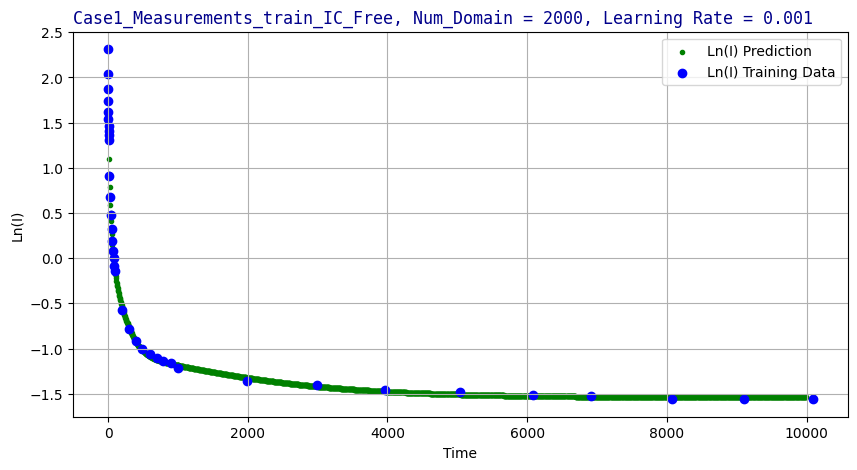

In [ ]:
#.....Ln_Case1_highest_density.....#
"""Backend supported: tensorflow.compat.v1, tensorflow, pytorch, jax"""
import deepxde as dde
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import tensorflow as tf

seed = 0
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

#Define constants.
U_dc = 1

#Time Limitation.
T = 10000.0
N_Domain = 2000
LR = 0.001

#Define parameters as variables.
Rr = dde.Variable(1.0)
RC = dde.Variable(1.0)

#MeasurmentsI Data Frame.
array1 = np.array([1, 1.985873504, 2.971653338, 4.011916777, 4.971206812, 5.952153859, 6.945654867, 8.035779515, 9.060859, 10.04297213, 19.94407226,29.84423166, 39.60640468, 49.92569147, 58.76078126 ,69.75501826, 78.65330965, 89.45054065 ,100.8612462, 200.2976765, 302.3062197, 397.7658488, 492.8755967, 595.2155128, 706.5809945, 789.9126601, 898.3489039, 1004.296999, 1994.406801, 2984.423802, 3960.639623, 5035.567461, 6081.139607, 6915.935617, 8070.309252, 9099.797382, 10086.12677])
array2 = np.array([1.01E-12, 7.66E-13, 6.51E-13, 5.67E-13, 5.07E-13, 4.66E-13, 4.31E-13, 4.09E-13, 3.92E-13, 3.69E-13, 2.49E-13, 1.96E-13, 1.61E-13, 1.38E-13, 1.21E-13, 1.08E-13, 1.00E-13, 9.13E-14, 8.67E-14, 5.64E-14, 4.59E-14, 4.00E-14, 3.67E-14, 3.46E-14, 3.31E-14, 3.20E-14, 3.12E-14, 2.96E-14, 2.56E-14, 2.45E-14, 2.33E-14,2.27E-14, 2.21E-14, 2.17E-14, 2.11E-14, 2.10E-14, 2.10E-14])

Data = pd.DataFrame({'t': array1, 'Ln_I': np.log(array2 * 10**13)})


def gen_traindata():
    return np.reshape(Data['t'].values,(-1,1)), np.reshape(Data["Ln_I"].values,(-1,1))



# Define the Lorenz system
def Lorenz_system(t, Ln_I):
    dLn_I_t = dde.grad.jacobian(Ln_I, t, i=0)
    return [dLn_I_t - (1/(RC)*(1 - ((U_dc/Rr) * 1/(tf.exp(Ln_I)))))]



geom = dde.geometry.TimeDomain(0, T)




# Get the train data
observe_t, ob_Ln_I = gen_traindata()
observe_Ln_I = dde.icbc.PointSetBC(observe_t, ob_Ln_I, component=0)


data = dde.data.PDE(
    geom,
    Lorenz_system,
    [observe_Ln_I],
    num_domain=N_Domain,
    anchors=observe_t,
)

net = dde.nn.FNN([1] + [40] * 3 + [1], "tanh", "Glorot uniform")
model = dde.Model(data, net)

external_trainable_variables = [Rr, RC]
variable = dde.callbacks.VariableValue(
    external_trainable_variables, period=600, filename="variables.dat"
)

# Train using adam
model.compile(
    "adam", lr=LR, external_trainable_variables=external_trainable_variables, metrics=['accuracy']
)
losshistory, train_state = model.train(iterations=20000, callbacks=[variable])

# Train using L-BFGS
model.compile("L-BFGS", external_trainable_variables=external_trainable_variables)
losshistory, train_state = model.train(callbacks=[variable])


# Make predictions
t_test = data.test_x
Ln_I_pred = model.predict(t_test)



# Create a single figure for all plots
plt.figure(figsize=(10, 5))

# Plot log(I) Prediction
plt.scatter(t_test, Ln_I_pred, label='Ln(I) Prediction', c='green' , marker='.')
# Plot log(I) True
plt.scatter(observe_t, ob_Ln_I, label='Ln(I) Training Data', c='blue', marker='o')



plt.xlabel('Time')
plt.ylabel('Ln(I)')
plt.legend()
plt.title(f'Case1_Measurements_train_IC_Free, Num_Domain = {N_Domain}, Learning Rate = {LR}', loc='left', fontdict={'family': 'monospace', 'color':  'darkblue', 'weight': 'normal', 'size': 12})
plt.grid(True)

plt.show()



In [ ]:
!cat variables.dat

0 [1.00e+00, 1.00e+00]
600 [1.46e+00, 1.46e+00]
1200 [1.80e+00, 1.80e+00]
1800 [2.06e+00, 2.08e+00]
2400 [2.29e+00, 2.31e+00]
3000 [2.50e+00, 2.52e+00]
3600 [2.69e+00, 2.71e+00]
4200 [2.87e+00, 2.88e+00]
4800 [3.05e+00, 3.05e+00]
5400 [3.22e+00, 3.22e+00]
6000 [3.38e+00, 3.39e+00]
6600 [3.54e+00, 3.55e+00]
7200 [3.68e+00, 3.71e+00]
7800 [3.80e+00, 3.88e+00]
8400 [3.92e+00, 4.06e+00]
9000 [4.02e+00, 4.25e+00]
9600 [4.09e+00, 4.47e+00]
10200 [4.16e+00, 4.70e+00]
10800 [4.18e+00, 4.95e+00]
11400 [4.23e+00, 5.21e+00]
12000 [4.26e+00, 5.51e+00]
12600 [4.27e+00, 5.83e+00]
13200 [4.28e+00, 6.17e+00]
13800 [4.28e+00, 6.52e+00]
14400 [4.29e+00, 6.88e+00]
15000 [4.26e+00, 7.25e+00]
15600 [4.26e+00, 7.64e+00]
16200 [4.29e+00, 8.03e+00]
16800 [4.29e+00, 8.43e+00]
17400 [4.29e+00, 8.85e+00]
18000 [4.29e+00, 9.27e+00]
18600 [4.29e+00, 9.69e+00]
19200 [4.27e+00, 1.01e+01]
19800 [4.29e+00, 1.06e+01]
20000 [4.29e+00, 1.07e+01]
20000 [4.29e+00, 1.07e+01]
20099 [4.29e+00, 1.07e+01]


In [ ]:
# Load optimized values from the file
with open("variables.dat", "r") as file:
    lines = file.readlines()

# Extract the values from the last line
last_line_values = lines[-1].split("[")[1].split("]")[0].split(",")
R_r_p, RC_p = map(float, last_line_values)

# Predict the current at t=0
ln_I_pred_at_t0 = model.predict(np.array([[0.0]]))

# Convert ln(I) to I using the inverse of the natural logarithm
I_pred_at_t0 = (np.exp(ln_I_pred_at_t0))

# Print the predicted current at t=0
print(f'Predicted I at t=0: {I_pred_at_t0[0,0]}')
# Calculate R_T using the predicted current at t=0
R_T_pred = U_dc / I_pred_at_t0[0, 0]

# Calculate R_p using the R_T and the predicted R_r_p
R_pred = (R_r_p * R_T_pred)/(R_r_p - R_T_pred)

# Print the calculated resistance at t=0
print(f'Calculated R : {R_pred}')

# Assuming T is a constant defined earlier in your code
T = RC_p

# Calculate C using the calculated resistance and time constant
C_pred = T / R_pred

# Print the calculated capacitance
print(f'Calculated C: {C_pred}')

Predicted I at t=0: 6.922633171081543
Calculated R : 0.14948726753736089
Calculated C: 71.57800243640003


In [ ]:
# Load optimized values from the file
with open("variables.dat", "r") as file:
    lines = file.readlines()

# Extract the values from the last line
last_line_values = lines[-1].split("[")[1].split("]")[0].split(",")
R_r_p, RC_p = map(float, last_line_values)

# Predict the current at t=0
ln_I_pred_at_t0 = model.predict(np.array([[0.0]]))

# Convert ln(I) to I using the inverse of the natural logarithm
I_pred_at_t0 = (np.exp(ln_I_pred_at_t0))

# Print the predicted current at t=0
print(f'Predicted I at t=0: {I_pred_at_t0[0,0]}')
# Calculate R_T using the predicted current at t=0
R_T_pred = U_dc / I_pred_at_t0[0, 0]

# Calculate R_p using the R_T and the predicted R_r_p
R_pred = (R_r_p * R_T_pred)/(R_r_p - R_T_pred)

# Print the calculated resistance at t=0
print(f'Calculated R : {R_pred}')

# Assuming T is a constant defined earlier in your code
T = RC_p

# Calculate C using the calculated resistance and time constant
C_pred = T / R_pred

# Print the calculated capacitance
print(f'Calculated C: {C_pred}')

Predicted I at t=0: 10.985148429870605
Calculated R : 0.09300553547559182
Calculated C: 231.16903623056302
